# Setup

In [3]:
## Install required packages
#!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
#!pip install transformers==4.21.2
#!pip install sentencepiece==0.1.96
#!pip install datasets
#!pip install nltk
#!pip install sentence_transformers
#!pip install gensim


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support, classification_report, f1_score
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import torch
from transformers import XLMRobertaForSequenceClassification, BertForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, DataCollatorForLanguageModeling, AutoModelForMaskedLM, TrainingArguments, Trainer, BertModel
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from datasets import Dataset, DatasetDict
from utils import functions
import random
import nltk
from sentence_transformers import SentenceTransformer, LoggingHandler
from sentence_transformers import models, util, datasets, evaluation, losses
import re
from nltk.corpus import stopwords
from gensim.utils import tokenize as tk
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, strip_tags, strip_punctuation, strip_numeric, strip_multiple_whitespaces
from gensim.models import Doc2Vec
from collections import namedtuple
from gensim.models.phrases import Phrases, Phraser
from gensim.models.doc2vec import TaggedDocument
from sentence_transformers import SentenceTransformer, LoggingHandler
from sentence_transformers import models, util, datasets, evaluation, losses
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer
import umap.umap_ as umap
from sklearn.decomposition import PCA, TruncatedSVD



In [2]:
device = torch.device('cuda')
torch.cuda.get_device_name(device=None)


'NVIDIA GeForce RTX 3090'

In [3]:
## Pseudo-randomness for reproducibility
seed_val = 1234
torch.manual_seed(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)

# Example 1: Using CMP-annotated data as data for classification and supervised dimensionality reduction

### Data preparation

In [4]:
manifesto = pd.read_csv(os.path.join("data", "r_outputs","pulled_manifestoes.csv"), encoding="utf-8")

In [5]:
manifesto.head()

,text,election,code,pos,party_code,country_code,party,country,name,name_english
0,La France est plus riche que jamais.,2012,503,3,31021_201206,31,31021,France,Front de Gauche,Left Front
1,Mais jamais non plus cette richesse n'a été au...,2012,503,4,31021_201206,31,31021,France,Front de Gauche,Left Front
2,Les réformes libérales qui se sont encore accé...,2012,503,5,31021_201206,31,31021,France,Front de Gauche,Left Front
3,"La pauvreté et la précarité se sont étendues, ...",2012,503,6,31021_201206,31,31021,France,Front de Gauche,Left Front
4,L'égoïsme social des possédants viole l'intérê...,2012,503,7,31021_201206,31,31021,France,Front de Gauche,Left Front


In [6]:
set(manifesto.code)

{'000',
 '101',
 '102',
 '103',
 '103.1',
 '103.2',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '201',
 '201.1',
 '201.2',
 '202',
 '202.1',
 '202.2',
 '202.3',
 '202.4',
 '203',
 '204',
 '301',
 '302',
 '303',
 '304',
 '305',
 '305.1',
 '305.2',
 '305.3',
 '305.5',
 '305.6',
 '401',
 '402',
 '403',
 '404',
 '405',
 '406',
 '407',
 '408',
 '409',
 '410',
 '411',
 '412',
 '413',
 '414',
 '415',
 '416',
 '416.1',
 '416.2',
 '501',
 '502',
 '503',
 '504',
 '505',
 '506',
 '507',
 '601',
 '601.1',
 '601.2',
 '602',
 '602.1',
 '602.2',
 '603',
 '604',
 '605',
 '605.1',
 '605.2',
 '606',
 '606.1',
 '606.2',
 '607',
 '607.1',
 '607.2',
 '607.3',
 '608',
 '608.1',
 '608.2',
 '701',
 '702',
 '703',
 '703.1',
 '703.2',
 '704',
 '705',
 '706',
 'H'}

In [7]:
manifesto = manifesto[(manifesto.code.notna()) & ~(manifesto.code.isin(['000','H']))].reset_index(drop=True)

In [8]:
manifesto.head()

,text,election,code,pos,party_code,country_code,party,country,name,name_english
0,La France est plus riche que jamais.,2012,503,3,31021_201206,31,31021,France,Front de Gauche,Left Front
1,Mais jamais non plus cette richesse n'a été au...,2012,503,4,31021_201206,31,31021,France,Front de Gauche,Left Front
2,Les réformes libérales qui se sont encore accé...,2012,503,5,31021_201206,31,31021,France,Front de Gauche,Left Front
3,"La pauvreté et la précarité se sont étendues, ...",2012,503,6,31021_201206,31,31021,France,Front de Gauche,Left Front
4,L'égoïsme social des possédants viole l'intérê...,2012,503,7,31021_201206,31,31021,France,Front de Gauche,Left Front


In [9]:
def extract_code(code):
    if len(code.split('.')) > 1:
        return(int(code.split('.')[0]))
    else:
        return int(code)
manifesto['code_extract'] = manifesto['code'].apply(extract_code)

In [10]:
len(set(manifesto.code_extract))

56

In [11]:
def sentiment_code(code):
    if code in [104,201,203,305,401,402,407,414,505,601,603,605,606,410]:                                       ## social - liberal                                                  
        return('right')
    elif code in [103,105,106,107,202,403,404,406,412,413,504,506,701,501,416]:                                             ## social - liberal                                 
        return('left')
    else:
        return('neutral')

    

In [12]:
manifesto['sentiment'] = manifesto['code_extract'].apply(sentiment_code)

In [13]:
manifesto.groupby('sentiment').count()

,text,election,code,pos,party_code,country_code,party,country,name,name_english,code_extract
sentiment,,,,,,,,,,,
left,116160,116160,116160,116160,116160,116160,116160,116160,116160,116160,116160
neutral,117309,117309,117309,117309,117309,117309,117309,117309,117309,117309,117309
right,54695,54695,54695,54695,54695,54695,54695,54695,54695,54695,54695


In [14]:
manifesto.groupby(['country','election']).count()

text   code    pos  party_code  country_code  party  \
country        election                                                         
France         2012       4809   4809   4809        4809          4809   4809   
               2017       3460   3460   3460        3460          3460   3460   
Germany        1998       6046   6046   6046        6046          6046   6046   
               2002       7339   7339   7339        7339          7339   7339   
               2005       5479   5479   5479        5479          5479   5479   
               2009      11624  11624  11624       11624         11624  11624   
               2013      17629  17629  17629       17629         17629  17629   
               2017      14779  14779  14779       14779         14779  14779   
               2021      18407  18407  18407       18407         18407  18407   
Italy          2001       3829   3829   3829        3829          3829   3829   
               2008        718    718    718         718           718    718   
               2013       4301   4301   4301        4301          4301   4301   
               2018      10881  10881  10881       10881         10881  10881   
Spain          1996       4378   4378   4378        4378          4378   4378   
               2000      16794  16794  16794       16794         16794  16794   
               2004       6725   6725   6725        6725          6725   6725   
               2008      17803  17803  17803       17803         17803  17803   
               2011      14910  14910  14910       14910         14910  14910   
               2015      23545  23545  23545       23545         23545  23545   
               2016      18511  18511  18511       18511         18511  18511   
               2019      29881  29881  29881       29881         29881  29881   
United Kingdom 1997       1451   1451   1451        1451          1451   1451   
               2001       2195   2195   2195        2195          2195   2195   
               2015      11033  11033  11033       11033         11033  11033   
               2017       6988   6988   6988        6988          6988   6988   
               2019       9269   9269   9269        9269          9269   9269   
United States  1992        383    383    383         383           383    383   
               2004       2644   2644   2644        2644          2644   2644   
               2008       1002   1002   1002        1002          1002   1002   
               2012       2893   2893   2893        2893          2893   2893   
               2016       3679   3679   3679        3679          3679   3679   
               2020       4779   4779   4779        4779          4779   4779   

                          name  name_english  code_extract  sentiment  
country        election                                                
France         2012       4809          4809          4809       4809  
               2017       3460          3460          3460       3460  
Germany        1998       6046          6046          6046       6046  
               2002       7339          7339          7339       7339  
               2005       5479          5479          5479       5479  
               2009      11624         11624         11624      11624  
               2013      17629         17629         17629      17629  
               2017      14779         14779         14779      14779  
               2021      18407         18407         18407      18407  
Italy          2001       3829          3829          3829       3829  
               2008        718           718           718        718  
               2013       4301          4301          4301       4301  
               2018      10881         10881         10881      10881  
Spain          1996       4378          4378          4378       4378  
               2000      16794         16794         16794      16794  
               2004       6725          6725   

In [15]:
texts = manifesto['text'].tolist()

In [16]:
from statistics import stdev, mean
## Before
seq_len = [len(i.split()) for i in texts]
seq_len_mean = mean(seq_len)
seq_len_std = stdev(seq_len)
seq_len_max = max(seq_len)
seq_len_min = min(seq_len)
print('Mean length (word) is: {}'.format(seq_len_mean))
print('Std length (word) is: {}'.format(seq_len_std))
print('Min length (word) is: {}'.format(seq_len_min))
print('Max length (word) is: {}'.format(seq_len_max))

Mean length (word) is: 20.442796463125166
Std length (word) is: 12.823326822581686
Min length (word) is: 1
Max length (word) is: 160


<AxesSubplot: >

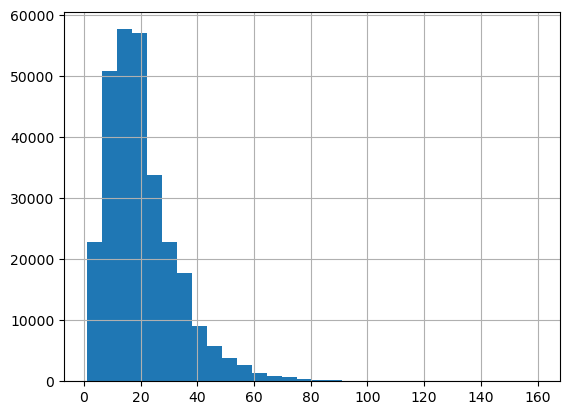

In [17]:
pd.Series(seq_len).hist(bins = 30)

In [18]:
manifesto.groupby('sentiment').count()

,text,election,code,pos,party_code,country_code,party,country,name,name_english,code_extract
sentiment,,,,,,,,,,,
left,116160,116160,116160,116160,116160,116160,116160,116160,116160,116160,116160
neutral,117309,117309,117309,117309,117309,117309,117309,117309,117309,117309,117309
right,54695,54695,54695,54695,54695,54695,54695,54695,54695,54695,54695


In [19]:
manifesto['country_party_election_sentiment'] = manifesto.country.str.cat(others=[manifesto.name, manifesto.election.astype(str), 
manifesto.sentiment], sep='_')

In [20]:
def group_texts(dataset, labels_col, text_col, group_factor=5):
    results = []
    labels = dataset[labels_col].tolist()
    for label in set(labels):
        ls_texts = []
        current_label = dataset[dataset[labels_col] == label]
        print(f'Length of {label} is: {len(current_label)}')
        texts = current_label[text_col].tolist()
        total_length = len(texts)
        for i in range(0,total_length,group_factor):
            text_to_append = ' '.join(texts[i:i+group_factor])
            ls_texts.append(text_to_append)
        result = {
            'text': ls_texts,
            'labels': label
        }                  
        results.append(result)
    return(results)   

In [ ]:
results = group_texts(manifesto, 'country_party_election_sentiment','text', group_factor = 3)

In [22]:
manifesto_regrouped = pd.DataFrame(results)
manifesto_regrouped = manifesto_regrouped.explode('text').reset_index(drop=True)

In [23]:
df_cols = manifesto_regrouped['labels'].str.split('_', expand=True)
manifesto_regrouped = pd.concat([manifesto_regrouped, df_cols], axis=1)

In [24]:
manifesto_regrouped.columns = ['text', 'country_party_election_sentiment', 'country','party', 'election', 'sentiment']

In [25]:
manifesto_regrouped

,text,country_party_election_sentiment,country,party,election,sentiment
0,Geroa Bai es una coalición formada por Zabaltz...,Spain_Geroa Bai_2011_right,Spain,Geroa Bai,2011,right
1,"Por todo ello, Geroa Bai expresa el sentir de ...",Spain_Geroa Bai_2011_right,Spain,Geroa Bai,2011,right
2,Como formación electoral Geroa Bai es la apues...,Spain_Geroa Bai_2011_right,Spain,Geroa Bai,2011,right
3,Geroa Bai ofrece a la ciudadanía navarra una a...,Spain_Geroa Bai_2011_right,Spain,Geroa Bai,2011,right
4,Apoyamos esta afirmación en el comportamiento ...,Spain_Geroa Bai_2011_right,Spain,Geroa Bai,2011,right
...,...,...,...,...,...,...
96260,including by proposing an explicit role for Br...,United Kingdom_Liberal Democrats_2015_neutral,United Kingdom,Liberal Democrats,2015,neutral
96261,Reinforce the EU’s tools for tackling cross bo...,United Kingdom_Liberal Democrats_2015_neutral,United Kingdom,Liberal Democrats,2015,neutral
96262,while ensuring swift delivery of justice. Coop...,United Kingdom_Liberal Democrats_2015_neutral,United Kingdom,Liberal Democrats,2015,neutral
96263,"Support EU free movement, which is hugely bene...",United Kingdom_Liberal Democrats_2015_neutral,United Kingdom,Liberal Democrats,2015,neutral


### Classification with xlm-roberta-base

In [26]:
transformer_model = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(transformer_model)
data_collator = DataCollatorWithPadding(tokenizer)

In [27]:
manifesto_reduced = manifesto_regrouped[['sentiment','text']]

In [28]:
manifesto_dataset = Dataset.from_pandas(manifesto_reduced)
manifesto_dataset = manifesto_dataset.class_encode_column('sentiment')
manifesto_dataset = manifesto_dataset.rename_column('sentiment','labels')



Parameter 'function'=<function Dataset.class_encode_column.<locals>.cast_to_class_labels at 0x0000021AA2E90820> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Casting to class labels:   0%|          | 0/97 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/10 [00:00<?, ?ba/s]

In [29]:
train_test = manifesto_dataset.train_test_split(test_size=0.2, stratify_by_column='labels', seed=seed_val)
train_eval = train_test['train'].train_test_split(test_size=0.3, stratify_by_column='labels', seed=seed_val)

In [30]:
manifesto_datasets = DatasetDict({
    'train': train_eval['train'],
    'test': train_test['test'],
    'eval': train_eval['test']
})
manifesto_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 53908
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 19253
    })
    eval: Dataset({
        features: ['labels', 'text'],
        num_rows: 23104
    })
})

In [31]:
train_df = Dataset.to_pandas(manifesto_datasets['train'])

In [32]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_df.labels),y=train_df['labels'].tolist())
print(class_weights)


[0.82712697 0.81924562 1.75327674]


In [33]:
def tokenize_function(dataset):
    return tokenizer(dataset['text'], truncation=True)


In [34]:
tokenized_datasets = manifesto_datasets.map(tokenize_function, batched=True, remove_columns=['text'])

  0%|          | 0/54 [00:00<?, ?ba/s]

  0%|          | 0/20 [00:00<?, ?ba/s]

  0%|          | 0/24 [00:00<?, ?ba/s]

In [35]:
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

['labels', 'input_ids', 'attention_mask']

In [36]:
num_classes = len(set(manifesto['sentiment']))
model = XLMRobertaForSequenceClassification.from_pretrained(transformer_model, num_labels=num_classes).to(device)


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

In [37]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(class_weights).float().to(device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [51]:
## Declare important variables
batch_size = 32
num_epochs = 3
total_steps = len(tokenized_datasets['train'])/batch_size*num_epochs
logging_steps = total_steps//10
lr = 2e-5

In [52]:
training_args = TrainingArguments(
    output_dir="results/multilingual/manifesto_3cl",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=lr,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    logging_steps= logging_steps,
    num_train_epochs = num_epochs,
    save_strategy='epoch',
    load_best_model_at_end=True,
    optim='adamw_torch'
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [53]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None)
    matrix = confusion_matrix(labels, predictions)
    acc = matrix.diagonal()/matrix.sum(axis=1)
    return {
        'precision': precision.tolist(),
        'recall': recall.tolist(),
        'f1': f1.tolist(),
        'accuracy': acc.tolist()
    }
trainer = CustomTrainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["eval"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

Using cuda_amp half precision backend


In [54]:
trainer.train()

***** Running training *****
  Num examples = 53908
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 5055
  Number of trainable parameters = 278045955


  0%|          | 0/5055 [00:00<?, ?it/s]

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.8447, 'learning_rate': 1.8021760633036597e-05, 'epoch': 0.3}
{'loss': 0.6735, 'learning_rate': 1.6023738872403564e-05, 'epoch': 0.6}
{'loss': 0.6164, 'learning_rate': 1.4025717111770526e-05, 'epoch': 0.9}


***** Running Evaluation *****
  Num examples = 23104
  Batch size = 32


  0%|          | 0/722 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.8314375605033882, 0.8171049514333096, 0.5873710534542045]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.7380236305048335, 0.7337517285395171, 0.8554518552242204]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.7819506088539889, 0.7731883651852267, 0.6965063478824947]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.7380236305048335, 0.7337517285395171, 0.8554518552242204]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect s

{'eval_loss': 0.5913817286491394, 'eval_precision': [0.8314375605033882, 0.8171049514333096, 0.5873710534542045], 'eval_recall': [0.7380236305048335, 0.7337517285395171, 0.8554518552242204], 'eval_f1': [0.7819506088539889, 0.7731883651852267, 0.6965063478824947], 'eval_accuracy': [0.7380236305048335, 0.7337517285395171, 0.8554518552242204], 'eval_runtime': 36.7439, 'eval_samples_per_second': 628.785, 'eval_steps_per_second': 19.65, 'epoch': 1.0}


Model weights saved in results/multilingual/manifesto_3cl\checkpoint-1685\pytorch_model.bin
tokenizer config file saved in results/multilingual/manifesto_3cl\checkpoint-1685\tokenizer_config.json
Special tokens file saved in results/multilingual/manifesto_3cl\checkpoint-1685\special_tokens_map.json


{'loss': 0.5355, 'learning_rate': 1.2031651829871416e-05, 'epoch': 1.2}
{'loss': 0.4943, 'learning_rate': 1.0033630069238378e-05, 'epoch': 1.5}
{'loss': 0.4638, 'learning_rate': 8.035608308605341e-06, 'epoch': 1.8}


***** Running Evaluation *****
  Num examples = 23104
  Batch size = 32


  0%|          | 0/722 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.8219533275713051, 0.854404209998747, 0.6355888869950571]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8171858216970999, 0.7253483671949793, 0.8488504438880037]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8195626413874825, 0.7846047635484985, 0.7269005847953216]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8171858216970999, 0.7253483671949793, 0.8488504438880037]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so

{'eval_loss': 0.5324077010154724, 'eval_precision': [0.8219533275713051, 0.854404209998747, 0.6355888869950571], 'eval_recall': [0.8171858216970999, 0.7253483671949793, 0.8488504438880037], 'eval_f1': [0.8195626413874825, 0.7846047635484985, 0.7269005847953216], 'eval_accuracy': [0.8171858216970999, 0.7253483671949793, 0.8488504438880037], 'eval_runtime': 36.1619, 'eval_samples_per_second': 638.904, 'eval_steps_per_second': 19.966, 'epoch': 2.0}


Model weights saved in results/multilingual/manifesto_3cl\checkpoint-3370\pytorch_model.bin
tokenizer config file saved in results/multilingual/manifesto_3cl\checkpoint-3370\tokenizer_config.json
Special tokens file saved in results/multilingual/manifesto_3cl\checkpoint-3370\special_tokens_map.json


{'loss': 0.4298, 'learning_rate': 6.037586547972305e-06, 'epoch': 2.1}
{'loss': 0.3747, 'learning_rate': 4.0395647873392686e-06, 'epoch': 2.4}
{'loss': 0.3568, 'learning_rate': 2.0454995054401585e-06, 'epoch': 2.7}
{'loss': 0.3655, 'learning_rate': 4.747774480712166e-08, 'epoch': 3.0}


***** Running Evaluation *****
  Num examples = 23104
  Batch size = 32


  0%|          | 0/722 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.8306224246367382, 0.8401392111368909, 0.6843405549220829]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8227712137486574, 0.7703435804701627, 0.819713180059185]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8266781782862076, 0.8037289828533378, 0.7459347488348006]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8227712137486574, 0.7703435804701627, 0.819713180059185]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so 

{'eval_loss': 0.5480526089668274, 'eval_precision': [0.8306224246367382, 0.8401392111368909, 0.6843405549220829], 'eval_recall': [0.8227712137486574, 0.7703435804701627, 0.819713180059185], 'eval_f1': [0.8266781782862076, 0.8037289828533378, 0.7459347488348006], 'eval_accuracy': [0.8227712137486574, 0.7703435804701627, 0.819713180059185], 'eval_runtime': 36.0514, 'eval_samples_per_second': 640.863, 'eval_steps_per_second': 20.027, 'epoch': 3.0}


Model weights saved in results/multilingual/manifesto_3cl\checkpoint-5055\pytorch_model.bin
tokenizer config file saved in results/multilingual/manifesto_3cl\checkpoint-5055\tokenizer_config.json
Special tokens file saved in results/multilingual/manifesto_3cl\checkpoint-5055\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from results/multilingual/manifesto_3cl\checkpoint-3370 (score: 0.5324077010154724).


{'train_runtime': 1095.0836, 'train_samples_per_second': 147.682, 'train_steps_per_second': 4.616, 'train_loss': 0.5152700626060116, 'epoch': 3.0}


TrainOutput(global_step=5055, training_loss=0.5152700626060116, metrics={'train_runtime': 1095.0836, 'train_samples_per_second': 147.682, 'train_steps_per_second': 4.616, 'train_loss': 0.5152700626060116, 'epoch': 3.0})

In [55]:
res = trainer.evaluate(tokenized_datasets['test'])
print(sum(res['eval_f1'])/num_classes)

***** Running Evaluation *****
  Num examples = 19253
  Batch size = 32


  0%|          | 0/602 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.8221993833504625, 0.8603543248474022, 0.6452020202020202]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8249548852797113, 0.7376818994128159, 0.8374760994263862]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8235748294942736, 0.7943096694385265, 0.7288719838345418]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8249548852797113, 0.7376818994128159, 0.8374760994263862]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect s

0.7822521609224472


In [56]:
res_table = pd.DataFrame({'f1': np.round(res['eval_f1'],2), 'precision': np.round(res['eval_precision'],2), 
'recall': np.round(res['eval_recall'],2), 'accuracy': np.round(res['eval_accuracy'],2)})
res_table

,f1,precision,recall,accuracy
0,0.82,0.82,0.82,0.82
1,0.79,0.86,0.74,0.74
2,0.73,0.65,0.84,0.84


In [57]:
round(res_table.mean(axis=0),2)

f1           0.78
precision    0.78
recall       0.80
accuracy     0.80
dtype: float64

### Scaling with Sentence Transformer and supervised dimensionality reduction

#### Sentence Transformer to extract sentence embeddings

#### Manual neural network (UMAP + autoencoders)

## Validation: Comparing classification performances

#### Bags-of-words with TF-IDF

In [79]:
## Preprocessing for bag-of-words and word2vec models is a little different (pre-trained)
## Tokenizer - use gensim's tokenizer 
def clean_text(text, stopwords):
    custom_filters = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_numeric, strip_multiple_whitespaces]
    text = preprocess_string(text, custom_filters)
    tokens = [w for w in text if w not in stopwords]
    return ' '.join(tokens)


In [80]:
set(manifesto_regrouped['country'])

{'France', 'Germany', 'Italy', 'Spain', 'United Kingdom'}

In [81]:
outputs = []
for idx, text in enumerate(manifesto_regrouped['text']):
    if idx % 1000 ==0:
        print(f'Cleaning the {idx}th sentence')
    country = manifesto_regrouped.loc[idx,'country'].lower()
    if country == 'france':
        outputs.append(clean_text(text, stopwords.words('french')))
    elif country == 'germany':
        outputs.append(clean_text(text, stopwords.words('german')))
    elif country == 'italy':
        outputs.append(clean_text(text, stopwords.words('italian')))
    elif country == 'spain':
        outputs.append(clean_text(text, stopwords.words('spanish')))
    else:
        outputs.append(clean_text(text, stopwords.words('english')))

Cleaning the 0th sentence
Cleaning the 1000th sentence
Cleaning the 2000th sentence
Cleaning the 3000th sentence
Cleaning the 4000th sentence
Cleaning the 5000th sentence
Cleaning the 6000th sentence
Cleaning the 7000th sentence
Cleaning the 8000th sentence
Cleaning the 9000th sentence
Cleaning the 10000th sentence
Cleaning the 11000th sentence
Cleaning the 12000th sentence
Cleaning the 13000th sentence
Cleaning the 14000th sentence
Cleaning the 15000th sentence
Cleaning the 16000th sentence
Cleaning the 17000th sentence
Cleaning the 18000th sentence
Cleaning the 19000th sentence
Cleaning the 20000th sentence
Cleaning the 21000th sentence
Cleaning the 22000th sentence
Cleaning the 23000th sentence
Cleaning the 24000th sentence
Cleaning the 25000th sentence
Cleaning the 26000th sentence
Cleaning the 27000th sentence
Cleaning the 28000th sentence
Cleaning the 29000th sentence
Cleaning the 30000th sentence
Cleaning the 31000th sentence
Cleaning the 32000th sentence
Cleaning the 33000th se

In [82]:
manifesto_regrouped['text_cleaned'] = outputs

In [83]:
## Before
manifesto_regrouped.loc[0,'text']

"The problem: This country's education has been underfunded and undermined by repeated shifts in policy. Standards are too low, especially in core skills such as reading and maths. Britain is too low in the world league tables."

In [84]:
## After
outputs[0]

'problem country education underfunded undermined repeated shifts policy standards low especially core skills reading maths britain low world league tables'

In [86]:
df_train, df_test = train_test_split(manifesto_regrouped, test_size=0.2, stratify = manifesto_regrouped['sentiment'],random_state=seed_val)
df_train, df_eval = train_test_split(df_train, test_size=0.3, stratify = df_train['sentiment'], random_state=seed_val)
enc = OrdinalEncoder()

df_train['labels'] = enc.fit_transform(np.array(df_train['sentiment'].tolist()).reshape(-1,1))
df_test['labels'] = enc.fit_transform(np.array(df_test['sentiment'].tolist()).reshape(-1,1))
df_eval['labels'] = enc.fit_transform(np.array(df_eval['sentiment'].tolist()).reshape(-1,1))

df_train = df_train.reset_index(drop=True)
df_eval = df_eval.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)



In [87]:
y_train = np.array(df_train['labels'])
y_eval = np.array(df_eval['labels'])
y_test = np.array(df_test['labels'])

In [88]:
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [95]:
corp_train = df_train['text_cleaned'].tolist()
vectorizer.fit(corp_train)
X_train = vectorizer.transform(corp_train)
dic_vocabulary = vectorizer.vocabulary_

In [96]:
classifier = naive_bayes.MultinomialNB()

In [97]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = df_test["text_cleaned"].tolist()
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

In [98]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, predicted, average=None)
matrix = confusion_matrix(y_test, predicted)
accuracy = matrix.diagonal()/matrix.sum(axis=1)

In [99]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.71,0.69,0.73,0.73
1,0.67,0.67,0.68,0.68
2,0.50,0.56,0.45,0.45


In [100]:
round(res_table.mean(axis=0),2)

f1           0.63
precision    0.64
recall       0.62
accuracy     0.62
dtype: float64

In [105]:
## Save vectorizer and model to other variables
vect_bow = vectorizer
model_bow = model


#### Doc2Vec


In [32]:
## We train word2vec embeddings on the GermaParl dataset before using embeddings for classification
outputs = []
for idx, text in enumerate(manifesto_regrouped['text']):
    if idx % 1000 ==0:
        print(f'Cleaning the {idx}th sentence')
    country = manifesto_regrouped.loc[idx,'country'].lower()
    if country == 'france':
        outputs.append(clean_text(text, stopwords.words('french')))
    elif country == 'germany':
        outputs.append(clean_text(text, stopwords.words('german')))
    elif country == 'italy':
        outputs.append(clean_text(text, stopwords.words('italian')))
    elif country == 'spain':
        outputs.append(clean_text(text, stopwords.words('spanish')))
    else:
        outputs.append(clean_text(text, stopwords.words('english')))

Cleaning the 0th sentence
Cleaning the 1000th sentence
Cleaning the 2000th sentence
Cleaning the 3000th sentence
Cleaning the 4000th sentence
Cleaning the 5000th sentence
Cleaning the 6000th sentence
Cleaning the 7000th sentence
Cleaning the 8000th sentence
Cleaning the 9000th sentence
Cleaning the 10000th sentence
Cleaning the 11000th sentence
Cleaning the 12000th sentence
Cleaning the 13000th sentence
Cleaning the 14000th sentence
Cleaning the 15000th sentence
Cleaning the 16000th sentence
Cleaning the 17000th sentence
Cleaning the 18000th sentence
Cleaning the 19000th sentence
Cleaning the 20000th sentence
Cleaning the 21000th sentence
Cleaning the 22000th sentence
Cleaning the 23000th sentence
Cleaning the 24000th sentence
Cleaning the 25000th sentence
Cleaning the 26000th sentence
Cleaning the 27000th sentence
Cleaning the 28000th sentence
Cleaning the 29000th sentence
Cleaning the 30000th sentence
Cleaning the 31000th sentence
Cleaning the 32000th sentence
Cleaning the 33000th se

In [33]:
manifesto_regrouped['text_cleaned'] = outputs

In [106]:
manifesto_regrouped.head()

,text,country_party_election_sentiment,country,party,election,sentiment,text_cleaned
0,The problem: This country's education has been...,United Kingdom_Liberal Democrats_1997_left,United Kingdom,Liberal Democrats,1997,left,problem country education underfunded undermin...
1,Our commitment: Liberal Democrats will make ed...,United Kingdom_Liberal Democrats_1997_left,United Kingdom,Liberal Democrats,1997,left,commitment liberal democrats make education ne...
2,- Reduce primary school class sizes so that wi...,United Kingdom_Liberal Democrats_1997_left,United Kingdom,Liberal Democrats,1997,left,reduce primary school class sizes within years...
3,This will be the first call on our £2 billion ...,United Kingdom_Liberal Democrats_1997_left,United Kingdom,Liberal Democrats,1997,left,first call £ billion annual programme extra in...
4,We will ensure that those in early years educa...,United Kingdom_Liberal Democrats_1997_left,United Kingdom,Liberal Democrats,1997,left,ensure early years education supervised qualif...


In [107]:
class corpusIterator(object):
    def __init__(self, df, bigram=None, trigram=None):
        if bigram:
            self.bigram = bigram
        else:
            self.bigram = None
        if trigram:
            self.trigram = trigram
        else:
            self.trigram = None
        self.df = df
    def __iter__(self):
        for  index, row in self.df.iterrows():
            if index % 3000 == 0:
                print(f'Working on the {index+1}th sentence')
            text = row['text_cleaned']
            labels = row['sentiment']
            tokens = text.split()
            if self.bigram and self.trigram:
                self.words = self.trigram[self.bigram[tokens]]
            elif self.bigram and not self.trigram:
                self.words = self.bigram[tokens]
            else:
                self.words = tokens
            yield TaggedDocument(self.words, [labels])
            
class phraseIterator(object):
    def __init__(self, df):
        self.df = df
    def __iter__(self):
        for index, row in self.df.iterrows():
            if index % 3000 == 0:
                print(f'Working on the {index+1}th sentence')
            text = row['text_cleaned']
            yield text.split()

In [108]:
df_train, df_test = train_test_split(manifesto_regrouped, test_size=0.2, stratify = manifesto_regrouped['sentiment'],random_state=seed_val)
df_train, df_eval = train_test_split(df_train, test_size=0.3, stratify = df_train['sentiment'], random_state=seed_val)
enc = OrdinalEncoder()

df_train['labels'] = enc.fit_transform(np.array(df_train['sentiment'].tolist()).reshape(-1,1))
df_test['labels'] = enc.fit_transform(np.array(df_test['sentiment'].tolist()).reshape(-1,1))
df_eval['labels'] = enc.fit_transform(np.array(df_eval['sentiment'].tolist()).reshape(-1,1))

df_train = df_train.reset_index(drop=True)
df_eval = df_eval.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)



In [109]:
outputs_stream = phraseIterator(df_train)
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

Working on the 1th sentence
Working on the 3001th sentence
Working on the 6001th sentence
Working on the 9001th sentence
Working on the 12001th sentence
Working on the 15001th sentence
Working on the 18001th sentence
Working on the 21001th sentence
Working on the 24001th sentence
Working on the 27001th sentence
Working on the 30001th sentence
Working on the 33001th sentence
Working on the 36001th sentence
Working on the 39001th sentence
Working on the 42001th sentence
Working on the 45001th sentence
Working on the 48001th sentence
Working on the 51001th sentence
Working on the 1th sentence
Working on the 1th sentence
Working on the 3001th sentence
Working on the 6001th sentence
Working on the 9001th sentence
Working on the 12001th sentence
Working on the 15001th sentence
Working on the 18001th sentence
Working on the 21001th sentence
Working on the 24001th sentence
Working on the 27001th sentence
Working on the 30001th sentence
Working on the 33001th sentence
Working on the 36001th sen

In [110]:
model = Doc2Vec(vector_size=300, window=5, min_count=1, workers=8, epochs=10, seed=seed_val)
model.build_vocab(corpusIterator(df_train, bigram=bigram, trigram=trigram))
model.train(corpusIterator(df_train, bigram=bigram, trigram=trigram), total_examples=model.corpus_count, epochs=model.epochs)

Working on the 1th sentence
Working on the 3001th sentence
Working on the 6001th sentence
Working on the 9001th sentence
Working on the 12001th sentence
Working on the 15001th sentence
Working on the 18001th sentence
Working on the 21001th sentence
Working on the 24001th sentence
Working on the 27001th sentence
Working on the 30001th sentence
Working on the 33001th sentence
Working on the 36001th sentence
Working on the 39001th sentence
Working on the 42001th sentence
Working on the 45001th sentence
Working on the 48001th sentence
Working on the 51001th sentence
Working on the 1th sentence
Working on the 3001th sentence
Working on the 6001th sentence
Working on the 9001th sentence
Working on the 12001th sentence
Working on the 15001th sentence
Working on the 18001th sentence
Working on the 21001th sentence
Working on the 24001th sentence
Working on the 27001th sentence
Working on the 30001th sentence
Working on the 33001th sentence
Working on the 36001th sentence
Working on the 39001th

In [111]:
model.save(os.path.join('results', 'd2v','d2v_3cl'))

In [112]:
def test_doc2vec(dataset, model):
    res = []
    for index, row in dataset.iterrows():
        text = row['text_cleaned']
        infer = model.dv.most_similar(model.infer_vector(text.split()),topn=1)[0][0]
        if infer == 'right':
            res.append(2)
        elif infer == 'left':
            res.append(0)
        else:
            res.append(1)
    return np.array(res)


In [113]:
predicted = test_doc2vec(df_test, model)
labels = np.array(df_test['labels'].tolist())

In [114]:
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted, average=None)
matrix = confusion_matrix(labels, predicted)
accuracy = matrix.diagonal()/matrix.sum(axis=1)

In [115]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.65,0.61,0.69,0.69
1,0.54,0.56,0.52,0.52
2,0.39,0.42,0.37,0.37


In [116]:
round(res_table.mean(axis=0),2)

f1           0.53
precision    0.53
recall       0.53
accuracy     0.53
dtype: float64

In [56]:
def d2v_reduct(model):
    keys = [k for k in model.dv.index_to_key]
    M = model.vector_size
    P = len(keys)
    embed_dict = {}
    for i in range( P ):
        embed_dict.update({keys[i]: model.dv[keys[i]]})   
    return embed_dict



In [117]:
def d2v_pred(model, dataset):
    res = []
    for index, row in dataset.iterrows():
        text = row['text_cleaned']
        infer = model.infer_vector(text.split())
        res.append(infer)
    return np.array(res)


#### XLM-Roberta-XL

## Validation: supervised vs unsupervised dimensionality reduction

### Contextual embeddings: manual supervised dimensionality reduction technique vs PCA

### Doc2Vec embeddings: manual supervised dimensionality reduction technique vs PCA

### Contextual embeddings: manual supervised dimensionality reduction technique vs LDA

# Example 2: Stances toward Trump (from Bestvater and Monroe 2022) 

## Data preparation

## Classification with xlm-roberta-base

## Scaling with Sentence Transformer

## Validation: Comparing classification performances

### Bags-of-words with TF-IDF

### Doc2Vec

### XLM-Roberta-XL

## Validation: Mapping ideology affiliation against scaled positions

# Extensions

## Cross-lingual classification performance

## Extending to other definitions of ideologies: CAP - 4 classes

# Scaling with Sentence Transformers

## Supervised scaling with Sentence Transformers and UMAP

In [24]:
transformer_model = 'results/multilingual/manifesto_3cl/checkpoint-3190'
model = XLMRobertaForSequenceClassification.from_pretrained(transformer_model).to(device)
tokenizer = AutoTokenizer.from_pretrained(transformer_model)


In [312]:
manifesto_deu = manifesto[manifesto['country'] == 'Germany'].reset_index(drop=True)
manifesto_deu_rgr = manifesto_regrouped[manifesto_regrouped['country'] == 'Germany'].reset_index(drop=True)

In [313]:
def party_agg(name):
    if any([x in name for x in ['Linke','Sozialismus']]):
        return('PDS/Die Linke')
    elif name.find('Sozialdemokratische') != -1:
        return('SPD')
    elif name.find('Christlich') != -1:
        return('CDU/CSU')
    elif name.find('Freie') != -1:
        return('FDP')
    elif name.find('Grünen') != -1:
        return('Die Grünen')
    elif name.find('Alternative') != -1:
        return('AfD')
    else:
        return('NA')

    

In [ ]:
manifesto_deu['party_agg'] = manifesto_deu['name'].apply(party_agg)
manifesto_deu_rgr['party_agg'] = manifesto_deu_rgr['party'].apply(party_agg)

In [314]:
manifesto_deu = manifesto_deu[manifesto_deu.party_agg != 'NA'].reset_index(drop=True)
manifesto_deu_rgr = manifesto_deu_rgr[manifesto_deu_rgr.party_agg != 'NA'].reset_index(drop=True)

In [315]:
set(manifesto_deu['party_agg'])



{'AfD', 'CDU/CSU', 'Die Grünen', 'FDP', 'PDS/Die Linke', 'SPD'}

In [316]:
set(manifesto_deu_rgr['party_agg'])


{'AfD', 'CDU/CSU', 'Die Grünen', 'FDP', 'PDS/Die Linke', 'SPD'}

In [318]:
len(manifesto_deu)

78191

In [317]:
len(manifesto_deu_rgr)

26096

In [319]:
def cmp_scale(dataframe, group_vars, sent_var):
    relscale = []
    absscale = []
    logscale = []
    name_ls = []
    for name, group in dataframe.groupby(group_vars):
        text = group['text'].tolist()
        len_all = len(text)
        left = group[group[sent_var] =='left'][sent_var].tolist()
        right = group[group[sent_var] =='right'][sent_var].tolist()
        relscale.append((len(right)-len(left))/(len(left)+len(right)))
        absscale.append((len(right)-len(left))/len_all)
        logscale.append(np.log(len(right)+0.5) - np.log(len(left)+0.5))
        name_ls.append(name)
    return(absscale, relscale, logscale, name_ls)
    

In [320]:
absscale, relscale, logscale, name_ls = cmp_scale(manifesto_deu, group_vars=['party_agg','election'], sent_var='sentiment')

In [63]:
def encode_embeds(dataframe, group_vars, model):
    embed_dict = {}
    for name, group in dataframe.groupby(group_vars):
        text = group['text'].tolist()
        embeds = model.encode(text)
        embed_dict.update({name: embeds})
    document_embed = np.vstack(list(embed_dict.values()))
    return(document_embed)



In [323]:
texts = manifesto_deu_rgr['text'].tolist()

In [60]:
def get_prediction(model, texts):
  res = []
  with torch.no_grad():
    for idx, x in enumerate(texts):
      if idx % 1000 == 0:
        print(idx)
      inputs = tokenizer(x, padding=True, truncation=True, return_tensors="pt").to(device)
      # perform inference to our model
      outputs = model(**inputs)
      # get output probabilities by doing softmax
      logits = outputs['logits']
      argmax = logits.argmax(1)
      res.append(argmax)
  return res

In [325]:
results = get_prediction(model, texts)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000


In [326]:
guide_labels = np.array([pred.cpu().detach().numpy() for pred in results])

In [327]:
guide_labels.shape

(26096, 1)

In [328]:
word_embedding_model = models.Transformer(transformer_model)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model]).to(device)

Some weights of the model checkpoint at results/multilingual/manifesto_3cl/checkpoint-3190 were not used when initializing XLMRobertaModel: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at results/multilingual/manifesto_3cl/checkpoint-3190 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to b

In [329]:
document_embed = encode_embeds(manifesto_deu_rgr, ['party_agg','election'], model)

In [330]:
from sklearn.decomposition import TruncatedSVD

In [9]:
def scale_topic(document_embed, guide_labels, sparse=False, guidance_weight=0.8, **kwargs):
    y = guide_labels
    if len(y) <= 10000:
        k_recommended = 250
    elif 10000 <= len(y) <= 50000:
        k_recommended = 500
    elif len(y) >=50000:
        k_recommended = 1000
    if sparse:
        svd = TruncatedSVD(n_components=50)
        embeddings_reduced = svd.fit_transform(document_embed)
    else:
        pca = PCA(n_components=50)
        embeddings_reduced = pca.fit_transform(document_embed)
    embeddings = umap.UMAP(n_components=1, n_neighbors=k_recommended, n_epochs=500, metric='euclidean', 
                            target_weight=guidance_weight, low_memory=True, verbose=True, **kwargs).fit_transform(embeddings_reduced, y=y)

    return embeddings
        


In [333]:
results = scale_topic( document_embed=document_embed, guide_labels = guide_labels)

UMAP(n_components=1, n_epochs=500, n_neighbors=500, verbose=True)
Mon Apr 10 17:07:22 2023 Construct fuzzy simplicial set
Mon Apr 10 17:07:22 2023 Finding Nearest Neighbors
Mon Apr 10 17:07:22 2023 Building RP forest with 13 trees
Mon Apr 10 17:07:22 2023 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Mon Apr 10 17:08:01 2023 Finished Nearest Neighbor Search
Mon Apr 10 17:08:07 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon Apr 10 17:08:35 2023 Finished embedding


In [334]:
emb_mean_dict = {}
for name, group in manifesto_deu_rgr.groupby(['party_agg','election']):
    idx = group.index
    embed = results[idx]
    embed_mean = np.mean(embed, axis=0)
    emb_mean_dict.update({name: embed_mean})

In [335]:
final_embeds = np.stack(list(emb_mean_dict.values()))

In [336]:
np.corrcoef(logscale, final_embeds[:,0])

array([[ 1.        , -0.81297573],
       [-0.81297573,  1.        ]])

In [339]:
enc = OrdinalEncoder()
guide_labels = enc.fit_transform(np.array(manifesto_deu_rgr['sentiment'].tolist()).reshape(-1,1))

In [340]:
results = scale_topic(dataframe=manifesto_deu_rgr, document_embed=document_embed, code_var='sentiment', guide_labels = guide_labels, guidance_weight=0.5)

UMAP(n_components=1, n_epochs=500, n_neighbors=500, verbose=True)
Mon Apr 10 17:12:46 2023 Construct fuzzy simplicial set
Mon Apr 10 17:12:46 2023 Finding Nearest Neighbors
Mon Apr 10 17:12:46 2023 Building RP forest with 13 trees
Mon Apr 10 17:12:46 2023 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Mon Apr 10 17:13:25 2023 Finished Nearest Neighbor Search
Mon Apr 10 17:13:32 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon Apr 10 17:13:53 2023 Finished embedding


In [341]:
emb_mean_dict = {}
for name, group in manifesto_deu_rgr.groupby(['party_agg','election']):
    idx = group.index
    embed = results[idx]
    embed_mean = np.mean(embed, axis=0)
    emb_mean_dict.update({name: embed_mean})

In [342]:
final_embeds = np.stack(list(emb_mean_dict.values()))

In [343]:
np.corrcoef(logscale, final_embeds[:,0])

array([[ 1.        , -0.82447658],
       [-0.82447658,  1.        ]])

In [344]:
tfm_05 = final_embeds

In [461]:
labels = ['_'.join([str(n) for n in name]) for name, group in manifesto_deu_rgr.groupby(['party_agg','election'])]
party = [lab.split('_')[0] for lab in labels]
year = [int(lab.split('_')[1]) for lab in labels]
#sentiment = [lab.split('_')[2] for lab in labels]


## Supervised scaling with Doc2Vec and Bags-of-words

### Doc2Vec

In [345]:
model = Doc2Vec.load(os.path.join('results','d2v', 'd2v_3cl'))

In [346]:
manifesto_deu_rgr.head()

,text,country_party_election_sentiment,country,party,election,sentiment,text_cleaned,party_agg
0,"Deutschland hat eine Regierung, die mit großen...",Germany_Partei des Demokratischen Sozialismus_...,Germany,Partei des Demokratischen Sozialismus,2002,right,deutschland regierung großen hoffnungen gewähl...,PDS/Die Linke
1,"Wir schätzen den geistigen, kulturellen und et...",Germany_Partei des Demokratischen Sozialismus_...,Germany,Partei des Demokratischen Sozialismus,2002,right,schätzen geistigen kulturellen ethischen reich...,PDS/Die Linke
2,"SPD und Grüne einerseits, CDU/CSU andererseits...",Germany_Partei des Demokratischen Sozialismus_...,Germany,Partei des Demokratischen Sozialismus,2002,right,spd grüne einerseits cdu csu andererseits stre...,PDS/Die Linke
3,Die intellektuelle Debatte in der Bundesrepubl...,Germany_Partei des Demokratischen Sozialismus_...,Germany,Partei des Demokratischen Sozialismus,2002,right,intellektuelle debatte bundesrepublik gesellsc...,PDS/Die Linke
4,Die Partei des Demokratischen Sozialismus will...,Germany_Partei des Demokratischen Sozialismus_...,Germany,Partei des Demokratischen Sozialismus,2002,right,partei demokratischen sozialismus realistische...,PDS/Die Linke


In [347]:
document_embed = d2v_pred(model, manifesto_deu_rgr)

In [354]:
document_embed.shape

(26096, 300)

In [349]:
pca = PCA(n_components=1)
d2v_org = pca.fit_transform(document_embed)

In [350]:
d2v_org.shape

(26096, 1)

In [351]:
emb_mean_dict = {}
for name, group in manifesto_deu_rgr.groupby(['party_agg','election']):
    idx = group.index
    embed = d2v_org[idx]
    embed_mean = np.mean(embed, axis=0)
    emb_mean_dict.update({name: embed_mean})

In [352]:
final_embeds = np.stack(list(emb_mean_dict.values()))

In [353]:
d2v_embeds_org = final_embeds

In [355]:
d2v_preds = test_doc2vec(manifesto_deu_rgr, model)

In [356]:
guide_labels = d2v_preds.reshape(-1,1)

In [357]:
guide_labels.shape

(26096, 1)

In [358]:
results = scale_topic(dataframe=manifesto_deu_rgr, document_embed=document_embed, code_var='sentiment', guide_labels=guide_labels)

UMAP(n_components=1, n_epochs=500, n_neighbors=500, target_weight=0.8, verbose=True)
Mon Apr 10 17:16:28 2023 Construct fuzzy simplicial set
Mon Apr 10 17:16:28 2023 Finding Nearest Neighbors
Mon Apr 10 17:16:28 2023 Building RP forest with 13 trees
Mon Apr 10 17:16:28 2023 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Mon Apr 10 17:17:05 2023 Finished Nearest Neighbor Search
Mon Apr 10 17:17:11 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon Apr 10 17:17:42 2023 Finished embedding


In [359]:
emb_mean_dict = {}
for name, group in manifesto_deu_rgr.groupby(['party_agg','election']):
    idx = group.index
    embed = results[idx]
    embed_mean = np.mean(embed, axis=0)
    emb_mean_dict.update({name: embed_mean})

In [360]:
final_embeds = np.stack(list(emb_mean_dict.values()))

In [361]:
np.corrcoef(logscale, final_embeds[:,0])

array([[1.       , 0.9257443],
       [0.9257443, 1.       ]])

In [362]:
d2v_embeds = final_embeds

In [367]:
np.corrcoef(d2v_embeds_org[:,0], d2v_embeds[:,0])

array([[1.       , 0.2442411],
       [0.2442411, 1.       ]])

In [363]:
enc = OrdinalEncoder()
guide_labels = enc.fit_transform(np.array(manifesto_deu_rgr['sentiment'].tolist()).reshape(-1,1))

In [364]:
results = scale_topic(dataframe=manifesto_deu_rgr, document_embed=document_embed, code_var='sentiment', guide_labels=guide_labels, guidance_weight=0.5)

UMAP(n_components=1, n_epochs=500, n_neighbors=500, verbose=True)
Mon Apr 10 17:17:56 2023 Construct fuzzy simplicial set
Mon Apr 10 17:17:56 2023 Finding Nearest Neighbors
Mon Apr 10 17:17:56 2023 Building RP forest with 13 trees
Mon Apr 10 17:17:56 2023 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Mon Apr 10 17:18:35 2023 Finished Nearest Neighbor Search
Mon Apr 10 17:18:42 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon Apr 10 17:19:10 2023 Finished embedding


In [368]:
emb_mean_dict = {}
for name, group in manifesto_deu_rgr.groupby(['party_agg','election']):
    idx = group.index
    embed = results[idx]
    embed_mean = np.mean(embed, axis=0)
    emb_mean_dict.update({name: embed_mean})

In [369]:
final_embeds = np.stack(list(emb_mean_dict.values()))

In [370]:
d2v_05 = final_embeds

In [373]:
np.corrcoef(logscale, d2v_05[:,0])

array([[1.        , 0.19166086],
       [0.19166086, 1.        ]])

### Bags-of-words

In [374]:
model = model_bow

In [375]:
texts = manifesto_deu_rgr['text_cleaned'].tolist()

In [376]:
document_embed = vect_bow.fit_transform(texts)

In [377]:
guide_labels = model.predict(texts)

In [378]:
results = scale_topic(dataframe=manifesto_deu_rgr, document_embed=document_embed, code_var='sentiment', sparse = True,guide_labels=guide_labels)

UMAP(n_components=1, n_epochs=500, n_neighbors=500, target_weight=0.8, verbose=True)
Mon Apr 10 17:20:24 2023 Construct fuzzy simplicial set
Mon Apr 10 17:20:24 2023 Finding Nearest Neighbors
Mon Apr 10 17:20:24 2023 Building RP forest with 13 trees
Mon Apr 10 17:20:24 2023 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	 6  /  15
	 7  /  15
	Stopping threshold met -- exiting after 7 iterations
Mon Apr 10 17:21:18 2023 Finished Nearest Neighbor Search
Mon Apr 10 17:21:22 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon Apr 10 17:21:53 2023 Finished embedding


In [379]:
emb_mean_dict = {}
for name, group in manifesto_deu_rgr.groupby(['party_agg','election']):
    idx = group.index
    embed = results[idx]
    embed_mean = np.mean(embed, axis=0)
    emb_mean_dict.update({name: embed_mean})

In [380]:
final_embeds = np.stack(list(emb_mean_dict.values()))

In [381]:
np.corrcoef(logscale, final_embeds[:,0])

array([[1.        , 0.22539565],
       [0.22539565, 1.        ]])

In [382]:
bow_embeds = final_embeds

In [ ]:
transformer_embeds

In [387]:
df1 = pd.DataFrame({'roberta_dim': transformer_embeds[:,0],  'party': party, 'year': year, 'lr_log': logscale, 'lr_abs': absscale, 
                   'bow_dim': bow_embeds[:,0], 'd2v_dim': d2v_embeds[:,0],'d2v_org': d2v_embeds_org[:,0],
                   'tfm_05': tfm_05[:,0], 'd2v_05': d2v_05[:,0]} ) #,'dim2': score[:,1]


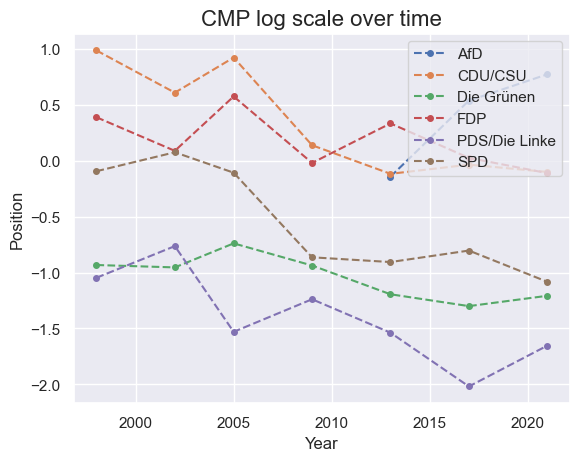

In [166]:
sns.set_theme()
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in df1.groupby('party'):
    ax.plot(group.year,group.lr_log, marker='o', linestyle='dashed', ms=4, label=name)
ax.legend(loc='upper right')
ax.set_xlabel('Year')
ax.set_ylabel('Position')
ax.set_title('CMP log scale over time', fontdict={'fontsize':16})
plt.plot()
plt.savefig('results/tabs and figs/figure5.png', dpi=300)

In [388]:
df1.to_csv(os.path.join('data','py_outputs','lr_deu_party.csv'))

In [389]:
df1

,roberta_dim,party,year,lr_log,lr_abs,bow_dim,d2v_dim,d2v_org,tfm_05,d2v_05
0,1.861886,AfD,2013,-0.143101,-0.041667,4.592098,0.733149,-0.278483,3.532417,8.901798
1,7.382490,AfD,2017,0.536458,0.174477,3.947175,8.712276,0.080919,3.328852,-0.800472
2,7.937183,AfD,2021,0.771917,0.245870,4.890751,10.869759,0.053116,1.116451,-0.226309
3,13.606391,CDU/CSU,1998,0.985217,0.305302,-0.194247,9.179988,-0.004772,1.510877,1.860072
4,8.666358,CDU/CSU,2002,0.607892,0.184068,-0.767532,7.671690,0.031855,0.139024,-0.864409
5,8.599796,CDU/CSU,2005,0.921853,0.247074,-0.117116,5.930357,-0.082282,-0.158449,1.746664
6,5.381460,CDU/CSU,2009,0.137832,0.037975,-0.591890,3.743273,-0.099137,0.663024,2.451614
7,4.680404,CDU/CSU,2013,-0.117708,-0.036306,0.943255,4.604713,-0.000546,3.939986,-0.732091
8,6.945989,CDU/CSU,2017,-0.035919,-0.011940,1.883396,3.902706,-0.055907,4.219203,1.452646
9,5.822617,CDU/CSU,2021,-0.101039,-0.032432,0.647190,3.807484,0.008673,3.946105,-0.760950


## Focus on one issue to show the differences 

In [292]:
transformer_model = 'results/multilingual/manifesto_3cl/checkpoint-3190'
model = XLMRobertaForSequenceClassification.from_pretrained(transformer_model).to(device)
tokenizer = AutoTokenizer.from_pretrained(transformer_model)


In [293]:
manifesto_env = manifesto[(manifesto['country'] == 'Germany') & (manifesto['code_extract'].isin([501,416,410]))].reset_index(drop=True)


In [294]:
manifesto_env['party_agg'] = manifesto_env['name'].apply(party_agg)
manifesto_env = manifesto_env[manifesto_env.party_agg != 'NA'].reset_index(drop=True)

In [295]:
absscale, relscale, logscale, name_ls = cmp_scale(manifesto_env, group_vars=['party_agg','election'], sent_var='sentiment')

In [296]:
texts = manifesto_env['text'].tolist()

In [298]:
transformer_model = 'results/multilingual/manifesto_3cl/checkpoint-3190'
word_embedding_model = models.Transformer(transformer_model)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model]).to(device)


Some weights of the model checkpoint at results/multilingual/manifesto_3cl/checkpoint-3190 were not used when initializing XLMRobertaModel: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at results/multilingual/manifesto_3cl/checkpoint-3190 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to b

In [299]:
document_embed = encode_embeds(manifesto_env, ['party_agg','election'], model)

In [300]:
document_embed.shape

(7005, 768)

In [301]:
enc = OrdinalEncoder()
guide_labels = enc.fit_transform(np.array(manifesto_env['sentiment'].tolist()).reshape(-1,1))

In [302]:
results = scale_topic(dataframe=manifesto_env, document_embed=document_embed, code_var='sentiment', guide_labels=guide_labels)

UMAP(n_components=1, n_epochs=500, n_neighbors=250, target_weight=0.8, verbose=True)
Mon Apr 10 15:26:48 2023 Construct fuzzy simplicial set
Mon Apr 10 15:26:48 2023 Finding Nearest Neighbors
Mon Apr 10 15:26:48 2023 Building RP forest with 9 trees
Mon Apr 10 15:26:48 2023 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Mon Apr 10 15:26:53 2023 Finished Nearest Neighbor Search
Mon Apr 10 15:26:54 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon Apr 10 15:27:02 2023 Finished embedding


In [303]:
emb_mean_dict = {}
for name, group in manifesto_env.groupby(['party_agg','election']):
    idx = group.index
    embed = results[idx]
    embed_mean = np.mean(embed, axis=0)
    emb_mean_dict.update({name: embed_mean})


In [304]:
final_embeds = np.stack(list(emb_mean_dict.values()))
labels = ['_'.join([str(n) for n in name]) for name, group in manifesto_env.groupby(['party_agg','election'])]
party = [lab.split('_')[0] for lab in labels]
year = [int(lab.split('_')[1]) for lab in labels]
#sentiment = [lab.split('_')[2] for lab in labels]



In [305]:
final_embeds.shape


(38, 1)

In [306]:
np.corrcoef(logscale, final_embeds[:,0])

array([[ 1.        , -0.86292558],
       [-0.86292558,  1.        ]])

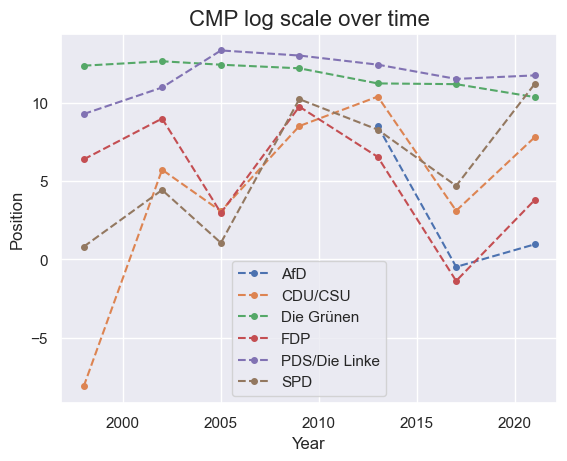

In [307]:
df = pd.DataFrame({'dim1': final_embeds[:,0],  'party': party, 'year': year, 'lr_prop': relscale, 'lr_log': logscale, 'lr_abs': absscale}) #,'dim2': score[:,1]
import matplotlib.pyplot as plt
sns.set_theme()
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in df.groupby('party'):
    ax.plot(group.year,group.dim1, marker='o', linestyle='dashed', ms=4, label=name)
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Position')
ax.set_title('CMP log scale over time', fontdict={'fontsize':16})
plt.plot()
plt.savefig('results/tabs and figs/figure5.png', dpi=300)

In [ ]:
manifesto_env.groupby(['party_agg','sentiment']).count()

In [271]:
manifesto_env.to_csv(os.path.join('data','py_outputs','env.csv'), encoding='utf-8')
df.to_csv(os.path.join('data','py_outputs','env_scores.csv'))

## How estimates differ with different levels of guidance weights

### Transformer with Doc2Vec predictions, supervision weight = 0.8

In [390]:
model = Doc2Vec.load(os.path.join('results','d2v', 'd2v_3cl'))

In [391]:
d2v_preds = test_doc2vec(manifesto_deu_rgr, model)

In [394]:
guide_labels = d2v_preds.reshape(-1,1)

In [392]:
word_embedding_model = models.Transformer(transformer_model)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model]).to(device)

Some weights of the model checkpoint at results/multilingual/manifesto_3cl/checkpoint-3190 were not used when initializing XLMRobertaModel: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at results/multilingual/manifesto_3cl/checkpoint-3190 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to b

In [393]:
document_embed = encode_embeds(manifesto_deu_rgr, ['party_agg','election'], model)

In [395]:
results = scale_topic(dataframe=manifesto_deu_rgr, document_embed=document_embed, code_var='sentiment', guide_labels=guide_labels, guidance_weight=0.8)

UMAP(n_components=1, n_epochs=500, n_neighbors=500, target_weight=0.8, verbose=True)
Mon Apr 10 17:55:31 2023 Construct fuzzy simplicial set
Mon Apr 10 17:55:31 2023 Finding Nearest Neighbors
Mon Apr 10 17:55:31 2023 Building RP forest with 13 trees
Mon Apr 10 17:55:31 2023 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Mon Apr 10 17:56:09 2023 Finished Nearest Neighbor Search
Mon Apr 10 17:56:15 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon Apr 10 17:56:40 2023 Finished embedding


In [396]:
emb_mean_dict = {}
for name, group in manifesto_deu_rgr.groupby(['party_agg','election']):
    idx = group.index
    embed = results[idx]
    embed_mean = np.mean(embed, axis=0)
    emb_mean_dict.update({name: embed_mean})

In [397]:
final_embeds = np.stack(list(emb_mean_dict.values()))

In [398]:
np.corrcoef(logscale, final_embeds[:,0])

array([[1.       , 0.7696812],
       [0.7696812, 1.       ]])

In [399]:
tf_d2vp = final_embeds

### Doc2Vec with Transformer predictions, supervision weight = 0.5

In [400]:
model = Doc2Vec.load(os.path.join('results','d2v', 'd2v_3cl'))

In [401]:
document_embed = d2v_pred(model, manifesto_deu_rgr)

In [404]:
transformer_model = 'results/multilingual/manifesto_3cl/checkpoint-3190'
model = XLMRobertaForSequenceClassification.from_pretrained(transformer_model).to(device)
tokenizer = AutoTokenizer.from_pretrained(transformer_model)


In [402]:
texts = manifesto_deu_rgr['text'].tolist()

In [405]:
def get_prediction(model, texts):
  res = []
  with torch.no_grad():
    for idx, x in enumerate(texts):
      if idx % 1000 == 0:
        print(idx)
      inputs = tokenizer(x, padding=True, truncation=True, return_tensors="pt").to(device)
      # perform inference to our model
      outputs = model(**inputs)
      # get output probabilities by doing softmax
      logits = outputs['logits']
      argmax = logits.argmax(1)
      res.append(argmax)
  return res

In [406]:
results = get_prediction(model, texts)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000


In [407]:
guide_labels = np.array([pred.cpu().detach().numpy() for pred in results])

In [408]:
results = scale_topic(dataframe=manifesto_deu_rgr, document_embed=document_embed, code_var='sentiment', guide_labels=guide_labels, guidance_weight=0.5)

UMAP(n_components=1, n_epochs=500, n_neighbors=500, verbose=True)
Mon Apr 10 18:06:07 2023 Construct fuzzy simplicial set
Mon Apr 10 18:06:07 2023 Finding Nearest Neighbors
Mon Apr 10 18:06:07 2023 Building RP forest with 13 trees
Mon Apr 10 18:06:07 2023 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Mon Apr 10 18:06:42 2023 Finished Nearest Neighbor Search
Mon Apr 10 18:06:49 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon Apr 10 18:07:12 2023 Finished embedding


In [409]:
emb_mean_dict = {}
for name, group in manifesto_deu_rgr.groupby(['party_agg','election']):
    idx = group.index
    embed = results[idx]
    embed_mean = np.mean(embed, axis=0)
    emb_mean_dict.update({name: embed_mean})

In [410]:
final_embeds = np.stack(list(emb_mean_dict.values()))

In [411]:
np.corrcoef(logscale, final_embeds[:,0])

array([[ 1.        , -0.10582136],
       [-0.10582136,  1.        ]])

In [413]:
d2v_tfp = final_embeds

In [460]:
len(tfm_05[:,0])

38

In [462]:
df1 = pd.DataFrame({'roberta_dim': transformer_embeds[:,0],  'party': party, 'year': year, 'lr_log': logscale, 'lr_abs': absscale, 
                   'bow_dim': bow_embeds[:,0], 'd2v_dim': d2v_embeds[:,0],'d2v_org': d2v_embeds_org[:,0],
                   'tf_d2vp': tf_d2vp[:,0], 'd2v_tfp': d2v_tfp[:,0], 'roberta_05': tfm_05[:,0]} ) #,'dim2': score[:,1]


In [463]:
df1.to_csv(os.path.join('data','py_outputs','lr_deu_party.csv'))

## Cross-domain extension: predicting political stances on Donald Trump using model trained on left - right CMP


### First, train a model for 2-class only

In [103]:
trump_tweets = pd.read_csv(os.path.join('data','sins_tweets','MOTN_responses_groundtruth.csv'))

In [104]:
len(trump_tweets)

7146

In [106]:
trump_tweets.groupby('trump_stance_auto').count()

,wavenum,ideo5,edits_clean_text,qpos,lexicoder_sentiment,fold,vader_sentiment,SVM_sentiment,BERT_sentiment,SVM_stance,BERT_stance,vader_scores
trump_stance_auto,,,,,,,,,,,,
0,4312,4312,4312,4312,1885,4312,2012,4312,4312,4312,4312,4312
1,2834,2834,2834,2834,1434,2834,1573,2834,2834,2834,2834,2834


In [107]:
trump_tweets.head()

,wavenum,ideo5,edits_clean_text,qpos,trump_stance_auto,lexicoder_sentiment,fold,vader_sentiment,SVM_sentiment,BERT_sentiment,SVM_stance,BERT_stance,vader_scores
0,3,Moderate,the recent election of donald trump the freedo...,1,1,1.0,3,1.0,1,1,1,0,0.6369
1,3,Very conservative,donald trump won,1,1,1.0,1,1.0,1,1,1,1,0.5719
2,3,Conservative,that donald trump beat hillary clinton,1,1,NaN,5,NaN,1,1,1,1,0.0000
3,3,Conservative,donald trump was elected president,1,1,NaN,5,NaN,1,1,1,1,0.0000
4,3,Conservative,the american people saw through the obfuscatio...,1,1,1.0,3,1.0,0,1,1,1,0.4019


In [ ]:
transformer_model = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(transformer_model)
data_collator = DataCollatorWithPadding(tokenizer)

In [110]:
trump_reduced = trump_tweets[['trump_stance_auto','edits_clean_text']]

In [111]:
trump_dataset = Dataset.from_pandas(trump_reduced)
trump_dataset = trump_dataset.class_encode_column('trump_stance_auto')
trump_dataset = trump_dataset.rename_column('trump_stance_auto','labels')



Stringifying the column:   0%|          | 0/8 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/8 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

In [112]:
train_test = trump_dataset.train_test_split(test_size=0.8, stratify_by_column='labels', seed=seed_val)
train_eval = train_test['train'].train_test_split(test_size=0.25, stratify_by_column='labels', seed=seed_val)

In [114]:
trump_datasets = DatasetDict({
    'train': train_eval['train'],
    'test': train_test['test'],
    'eval': train_eval['test']
})
trump_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'edits_clean_text'],
        num_rows: 1071
    })
    test: Dataset({
        features: ['labels', 'edits_clean_text'],
        num_rows: 5717
    })
    eval: Dataset({
        features: ['labels', 'edits_clean_text'],
        num_rows: 358
    })
})

In [115]:
train_df = Dataset.to_pandas(trump_datasets['train'])

In [116]:
train_df.groupby('labels').count()

,edits_clean_text
labels,
0,646
1,425


In [117]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_df.labels),y=train_df['labels'].tolist())
print(class_weights)


[0.82894737 1.26      ]


In [121]:
def tokenize_function(dataset):
    return tokenizer(dataset['edits_clean_text'], truncation=True)


In [123]:
tokenized_datasets = trump_datasets.map(tokenize_function, batched=True, remove_columns=['edits_clean_text'])

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [124]:
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

['labels', 'input_ids', 'attention_mask']

In [127]:
num_classes = len(set(trump_tweets['trump_stance_auto']))
model = XLMRobertaForSequenceClassification.from_pretrained(transformer_model, num_labels=num_classes).to(device)


loading configuration file config.json from cache at C:\Users\Hung/.cache\huggingface\hub\models--xlm-roberta-base\snapshots\77de1f7a7e5e737aead1cd880979d4f1b3af6668\config.json
Model config XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

loading weights file pytorch_model.bin from cache at C:\Users\Hung/.cache\huggingface\hub\models--xlm-roberta-base\snapshots\77de1f7a7e5e737aead1cd8809

In [128]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(class_weights).float().to(device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [130]:
batch_size = 32
training_args = TrainingArguments(
    output_dir="results/multilingual/trump_2cl",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    logging_steps= 100,
    num_train_epochs = 3,
    save_strategy='epoch',
    load_best_model_at_end=True,
    optim='adamw_torch'
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [131]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None)
    matrix = confusion_matrix(labels, predictions)
    acc = matrix.diagonal()/matrix.sum(axis=1)
    return {
        'precision': precision.tolist(),
        'recall': recall.tolist(),
        'f1': f1.tolist(),
        'accuracy': acc.tolist()
    }
trainer = CustomTrainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["eval"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

Using cuda_amp half precision backend


In [132]:
trainer.train()

***** Running training *****
  Num examples = 1071
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 102
  Number of trainable parameters = 278045186


  0%|          | 0/102 [00:00<?, ?it/s]

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
***** Running Evaluation *****
  Num examples = 358
  Batch size = 32


  0%|          | 0/12 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.671875, 0.41156462585034015]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.19907407407407407, 0.852112676056338]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.30714285714285716, 0.5550458715596329]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.19907407407407407, 0.852112676056338]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/multilingual/trump_2cl\c

{'eval_loss': 0.6908105611801147, 'eval_precision': [0.671875, 0.41156462585034015], 'eval_recall': [0.19907407407407407, 0.852112676056338], 'eval_f1': [0.30714285714285716, 0.5550458715596329], 'eval_accuracy': [0.19907407407407407, 0.852112676056338], 'eval_runtime': 0.3768, 'eval_samples_per_second': 950.068, 'eval_steps_per_second': 31.846, 'epoch': 1.0}


Model weights saved in results/multilingual/trump_2cl\checkpoint-34\pytorch_model.bin
tokenizer config file saved in results/multilingual/trump_2cl\checkpoint-34\tokenizer_config.json
Special tokens file saved in results/multilingual/trump_2cl\checkpoint-34\special_tokens_map.json
***** Running Evaluation *****
  Num examples = 358
  Batch size = 32


  0%|          | 0/12 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.6784140969162996, 0.5267175572519084]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.7129629629629629, 0.4859154929577465]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6952595936794582, 0.5054945054945056]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.7129629629629629, 0.4859154929577465]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/multilingual/tru

{'eval_loss': 0.6777951717376709, 'eval_precision': [0.6784140969162996, 0.5267175572519084], 'eval_recall': [0.7129629629629629, 0.4859154929577465], 'eval_f1': [0.6952595936794582, 0.5054945054945056], 'eval_accuracy': [0.7129629629629629, 0.4859154929577465], 'eval_runtime': 0.3608, 'eval_samples_per_second': 992.304, 'eval_steps_per_second': 33.262, 'epoch': 2.0}


Model weights saved in results/multilingual/trump_2cl\checkpoint-68\pytorch_model.bin
tokenizer config file saved in results/multilingual/trump_2cl\checkpoint-68\tokenizer_config.json
Special tokens file saved in results/multilingual/trump_2cl\checkpoint-68\special_tokens_map.json


{'loss': 0.6826, 'learning_rate': 7.843137254901962e-07, 'epoch': 2.94}


***** Running Evaluation *****
  Num examples = 358
  Batch size = 32


  0%|          | 0/12 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.7166666666666667, 0.5112359550561798]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.5972222222222222, 0.6408450704225352]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6515151515151515, 0.56875]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.5972222222222222, 0.6408450704225352]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/multilingual/trump_2cl\chec

{'eval_loss': 0.6416300535202026, 'eval_precision': [0.7166666666666667, 0.5112359550561798], 'eval_recall': [0.5972222222222222, 0.6408450704225352], 'eval_f1': [0.6515151515151515, 0.56875], 'eval_accuracy': [0.5972222222222222, 0.6408450704225352], 'eval_runtime': 0.3772, 'eval_samples_per_second': 949.216, 'eval_steps_per_second': 31.817, 'epoch': 3.0}


Model weights saved in results/multilingual/trump_2cl\checkpoint-102\pytorch_model.bin
tokenizer config file saved in results/multilingual/trump_2cl\checkpoint-102\tokenizer_config.json
Special tokens file saved in results/multilingual/trump_2cl\checkpoint-102\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from results/multilingual/trump_2cl\checkpoint-102 (score: 0.6416300535202026).


{'train_runtime': 28.3998, 'train_samples_per_second': 113.135, 'train_steps_per_second': 3.592, 'train_loss': 0.6809998844184127, 'epoch': 3.0}


TrainOutput(global_step=102, training_loss=0.6809998844184127, metrics={'train_runtime': 28.3998, 'train_samples_per_second': 113.135, 'train_steps_per_second': 3.592, 'train_loss': 0.6809998844184127, 'epoch': 3.0})

In [133]:
res = trainer.evaluate(tokenized_datasets['test'])
print(sum(res['eval_f1'])/num_classes)

***** Running Evaluation *****
  Num examples = 5717
  Batch size = 32


  0%|          | 0/179 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.7274640477025605, 0.5198883461270063]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.601159420289855, 0.6572562858403176]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.658308205046818, 0.5805571790375997]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.601159420289855, 0.6572562858403176]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


0.6194326920422089


In [134]:
res_table = pd.DataFrame({'f1': np.round(res['eval_f1'],2), 'precision': np.round(res['eval_precision'],2), 
'recall': np.round(res['eval_recall'],2), 'accuracy': np.round(res['eval_accuracy'],2)})
res_table

,f1,precision,recall,accuracy
0,0.66,0.73,0.60,0.60
1,0.58,0.52,0.66,0.66


In [135]:
round(res_table.mean(axis=0),2)

f1           0.62
precision    0.62
recall       0.63
accuracy     0.63
dtype: float64

### Apply on tweets about Donald Trump from the paper Sentiment is not Stance

In [55]:
sins_trump = pd.read_csv(os.path.join('data','sins_tweets', 'MOTN_responses_groundtruth.csv'))

In [56]:
sins_trump.head()

,wavenum,ideo5,edits_clean_text,qpos,trump_stance_auto,lexicoder_sentiment,fold,vader_sentiment,SVM_sentiment,BERT_sentiment,SVM_stance,BERT_stance,vader_scores
0,3,Moderate,the recent election of donald trump the freedo...,1,1,1.0,3,1.0,1,1,1,0,0.6369
1,3,Very conservative,donald trump won,1,1,1.0,1,1.0,1,1,1,1,0.5719
2,3,Conservative,that donald trump beat hillary clinton,1,1,NaN,5,NaN,1,1,1,1,0.0000
3,3,Conservative,donald trump was elected president,1,1,NaN,5,NaN,1,1,1,1,0.0000
4,3,Conservative,the american people saw through the obfuscatio...,1,1,1.0,3,1.0,0,1,1,1,0.4019


In [57]:
sins_trump.groupby('trump_stance_auto').count()

,wavenum,ideo5,edits_clean_text,qpos,lexicoder_sentiment,fold,vader_sentiment,SVM_sentiment,BERT_sentiment,SVM_stance,BERT_stance,vader_scores
trump_stance_auto,,,,,,,,,,,,
0,4312,4312,4312,4312,1885,4312,2012,4312,4312,4312,4312,4312
1,2834,2834,2834,2834,1434,2834,1573,2834,2834,2834,2834,2834


In [94]:
transformer_model = 'results/multilingual/kvn_2cl/checkpoint-234'
model = XLMRobertaForSequenceClassification.from_pretrained(transformer_model).to(device)
tokenizer = AutoTokenizer.from_pretrained(transformer_model)


loading configuration file results/multilingual/kvn_2cl/checkpoint-234\config.json
Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

loading weights file results/multilingual/kvn_2cl/checkpoint-234\pytorch_model.bin
All model checkpoint weights were

In [95]:
texts = sins_trump['edits_clean_text'].tolist()

In [96]:
results = get_prediction(model, texts)

0
1000
2000
3000
4000
5000
6000
7000


In [97]:
predicted = np.array([i.cpu().detach().numpy() for i in results]).flatten()

In [98]:
predicted.shape

(7146,)

In [99]:
y_truth = np.array(sins_trump['trump_stance_auto'].tolist())

In [204]:
y_truth.shape

(7146,)

In [100]:
precision, recall, f1, _ = precision_recall_fscore_support(y_truth, predicted, average=None)
matrix = confusion_matrix(y_truth, predicted)
accuracy = matrix.diagonal()/matrix.sum(axis=1)

In [102]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.41,0.69,0.29,0.29
1,0.56,0.43,0.80,0.80


### Dimension reduction with UMAP

In [212]:
def encode_embeds(dataframe, group_vars, model):
    embed_dict = {}
    for name, group in dataframe.groupby(group_vars):
        text = group['edits_clean_text'].tolist()
        embeds = model.encode(text)
        embed_dict.update({name: embeds})
    document_embed = np.vstack(list(embed_dict.values()))
    return(document_embed)



In [233]:
guide_labels = np.array(sins_trump['trump_stance_auto'].tolist()).reshape(-1,1)

In [234]:
guide_labels.shape

(7146, 1)

In [227]:
word_embedding_model = models.Transformer(transformer_model)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model]).to(device)

loading configuration file results/multilingual/manifesto_2cl/checkpoint-3000\config.json
Model config XLMRobertaConfig {
  "_name_or_path": "results/multilingual/manifesto_2cl/checkpoint-3000",
  "architectures": [
    "XLMRobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

loading weights file results/multilingual/manifesto_2cl/checkpoint-3000\pyt

In [228]:
document_embed = encode_embeds(sins_trump, 'ideo5', model)

In [229]:
def scale_topic(document_embed, guide_labels, sparse=False, guidance_weight=0.8, **kwargs):
    y = guide_labels
    if len(y) <= 10000:
        k_recommended = 250
    elif 10000 <= len(y) <= 50000:
        k_recommended = 500
    elif len(y) >=50000:
        k_recommended = 1000
    if sparse:
        svd = TruncatedSVD(n_components=50)
        embeddings_reduced = svd.fit_transform(document_embed)
    else:
        pca = PCA(n_components=50)
        embeddings_reduced = pca.fit_transform(document_embed)
    embeddings = umap.UMAP(n_components=1, n_neighbors=k_recommended, n_epochs=500, metric='euclidean', 
                            target_weight=guidance_weight, low_memory=True, verbose=True, **kwargs).fit_transform(embeddings_reduced, y=y)

    return embeddings
        


In [235]:
results = scale_topic( document_embed=document_embed, guide_labels = guide_labels)

UMAP(n_components=1, n_epochs=500, n_neighbors=250, target_weight=0.8, verbose=True)
Tue May  9 15:13:33 2023 Construct fuzzy simplicial set
Tue May  9 15:13:33 2023 Finding Nearest Neighbors
Tue May  9 15:13:33 2023 Building RP forest with 9 trees
Tue May  9 15:13:33 2023 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Tue May  9 15:13:38 2023 Finished Nearest Neighbor Search
Tue May  9 15:13:39 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Tue May  9 15:13:52 2023 Finished embedding


In [236]:
emb_mean_dict = {}
for name, group in sins_trump.groupby('ideo5'):
    idx = group.index
    embed = results[idx]
    embed_mean = np.mean(embed, axis=0)
    emb_mean_dict.update({name: embed_mean})


In [237]:
final_embeds = np.stack(list(emb_mean_dict.values()))

In [238]:
sins_trump.groupby(['ideo5','trump_stance_auto']).count()

wavenum  edits_clean_text  qpos  \
ideo5             trump_stance_auto                                    
Conservative      0                      177               177   177   
                  1                     1204              1204  1204   
Liberal           0                     1481              1481  1481   
                  1                       54                54    54   
Moderate          0                     1339              1339  1339   
                  1                      514               514   514   
Not sure          0                      142               142   142   
                  1                       62                62    62   
Very conservative 0                       65                65    65   
                  1                      973               973   973   
Very liberal      0                     1108              1108  1108   
                  1                       27                27    27   

                                     lexicoder_sentiment  fold  \
ideo5             trump_stance_auto                              
Conservative      0                                   69   177   
                  1                                  616  1204   
Liberal           0                                  692  1481   
                  1                                   24    54   
Moderate          0                                  564  1339   
                  1                                  269   514   
Not sure          0                                   45   142   
                  1                                   22    62   
Very conservative 0                                   30    65   
                  1                                  498   973   
Very liberal      0                                  485  1108   
                  1                                    5    27   

                                     vader_sentiment  SVM_sentiment  \
ideo5             trump_stance_auto                                   
Conservative      0                               76            177   
                  1                              668           1204   
Liberal           0                              733           1481   
                  1                               29             54   
Moderate          0                              605           1339   
                  1                              300            514   
Not sure          0                               49            142   
                  1                               31             62   
Very conservative 0                               32             65   
                  1                              536            973   
Very liberal      0                              517           1108   
                  1                                9             27   

                                     BERT_sentiment  SVM_stance  BERT_stance  \
ideo5             trump_stance_auto                                            
Conservative      0                             177         177          177   
                  1                            1204        1204         1204   
Liberal           0                            1481        1481         1481   
                  1                              54          54           54   
Moderate          0                            1339        1339         1339   
                  1                             514         514          514   
Not sure          0                             142         142          142   
                  1                              62          62           62   
Very conservative 0                              65          65           65   
                  1                             973         973          973   
Very liberal      0                            1108        1108         1108   
                  1                              27          27     

In [239]:
final_embeds

array([[ 20.764511 ],
       [-11.03211  ],
       [ -1.1955696],
       [  0.6113985],
       [ 23.709496 ],
       [-10.032596 ]], dtype=float32)

In [1]:
27/1108 - 54/1481


-0.01209361905435151

## Misc 

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=seed_val)
pca_embed = pca.fit_transform(document_embed)

In [182]:
cluster = hdbscan.HDBSCAN(min_cluster_size=3,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(pca_embed)

In [183]:
cluster.labels_

array([-1,  2, -1,  0,  0,  0, -1, -1,  2,  2,  2,  2,  2,  2,  1,  2,  2,
        2,  2,  2, -1, -1,  1,  1, -1,  2,  2,  2, -1,  2, -1, -1,  2,  2,
        2], dtype=int64)

In [140]:
document_embed.shape

(35, 3)

In [498]:
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(document_embed)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

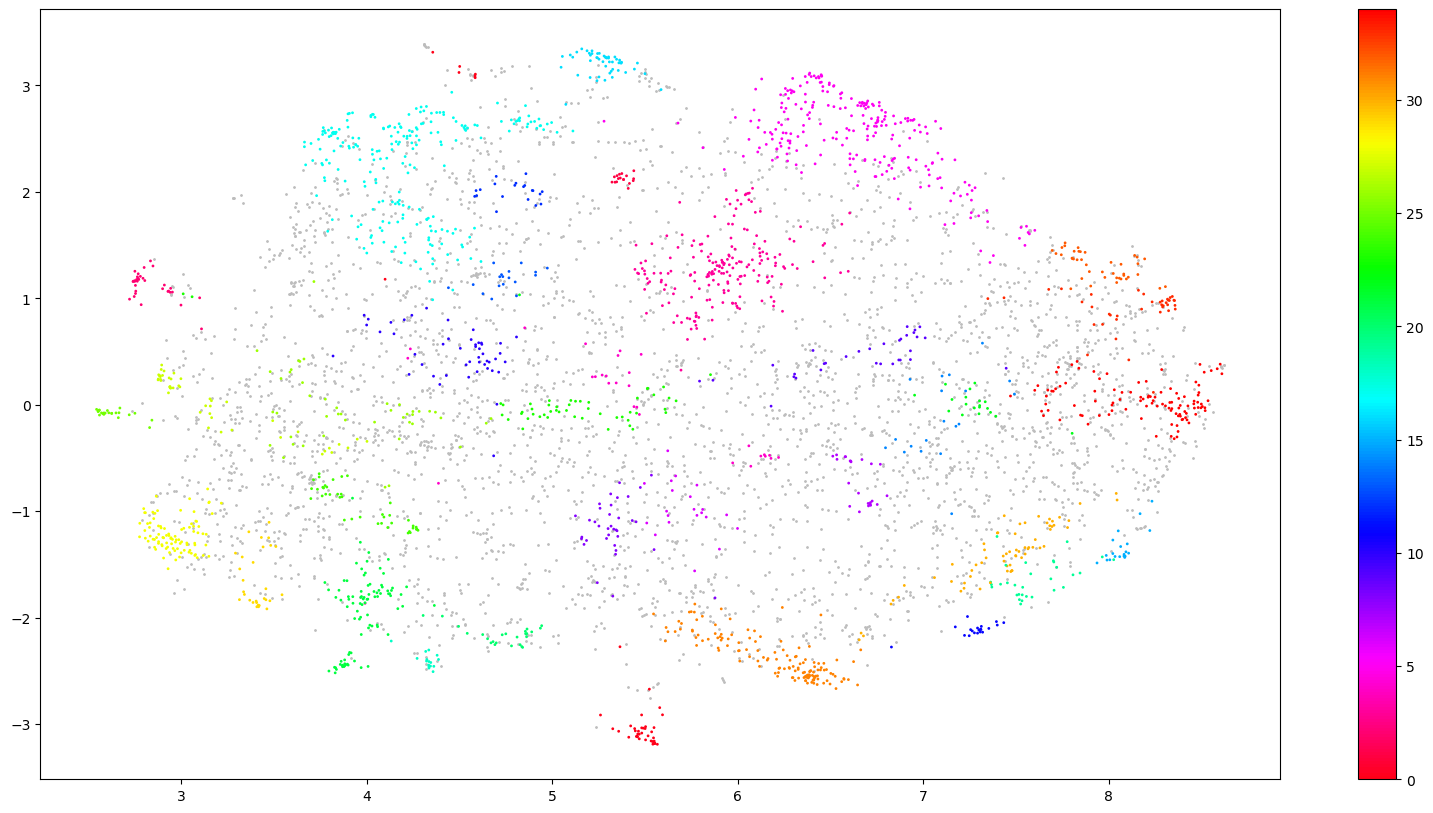

In [502]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=1)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=1, cmap='hsv_r')
plt.colorbar()

In [ ]:
docs_df = pd.DataFrame(manifesto_welfare['text'].tolist(), columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [150]:
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words=stopwords.words('german')).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(manifesto_welfare['text'].tolist()))

In [151]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,3394
3,2,934
2,1,627
1,0,232


In [148]:
from sklearn.metrics.pairwise import cosine_similarity
for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(manifesto_welfare['text'].tolist())
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,5187


In [154]:
top_n_words[2][:20]

[('rente', 0.0386656175170545),
 ('altersvorsorge', 0.030643967244284004),
 ('rentenversicherung', 0.02440442182644493),
 ('kindergeld', 0.022400303538711978),
 ('müssen', 0.020437202206478423),
 ('private', 0.019964771430003126),
 ('gesetzlichen', 0.01860772532188563),
 ('altersarmut', 0.0181979623140137),
 ('alterssicherung', 0.017720215004242906),
 ('grundsicherung', 0.01767733905579135),
 ('gesetzliche', 0.017572755096767607),
 ('menschen', 0.01725232659521793),
 ('vorsorge', 0.016646262579743335),
 ('leistungen', 0.016580193036088507),
 ('alter', 0.01594378531548992),
 ('kinder', 0.015586618065077601),
 ('einführen', 0.015517385748632678),
 ('rentner', 0.015214105919124971),
 ('euro', 0.014711914568041448),
 ('einkommen', 0.014703566052634778)]

In [ ]:
topic_model = BERTopic(embedding_model="xlm-r-bert-base-nli-stsb-mean-tokens").fit(docs)

In [470]:
document_embed = np.stack(list(emb_mean_dict.values()))

In [464]:
len_text = (2*(len_text- np.min(len_text))/(np.max(len_text) - np.min(len_text)))-1
document_embed = np.multiply(document_embed, len_text.reshape(document_embed.shape[0],-1))

In [447]:
len_text

array([-0.01081081,  0.05783133,  0.575     ,  0.90810811,  0.54825175,
        0.95952381,  0.82274882, -1.        , -0.87586207, -0.13333333,
       -0.19220779, -0.81086957,  0.18148148,  0.41818182,  0.89634146,
        0.92916667,  0.83495146,  0.93982301,  0.93388889,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        0.98577406,  1.        ,  0.99344894,  0.07272727,  0.575     ,
        0.575     ,  0.9442623 ,  0.92013423,  1.        ,  1.        ])